# Benchmarking tests for TIsigner
##### We use the commandline version with parameters used for webversion. 

In [45]:
import timeit
from multiprocessing import Pool
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)
from libs import functions
from libs import data

#### Generate some random sequences with varying length

In [2]:

def rand_seq(length, rnd_state):
    seq = 'ATG' + ''.join(rnd_state.choice(list(data.CODON_TO_AA.keys()), length-2)) + 'TAG'
    return seq

rnd = np.random.RandomState(12345)
seqs = pd.DataFrame({'Sequence':[rand_seq(i, rnd) for i in range(30, 1500, 20)]})
seqs['Length'] = seqs['Sequence'].apply(len)

In [7]:
def benchmarking(s):
    '''
    We take params from webversion
    '''
    start = timeit.default_timer()
    d = 0 #seed
    r = 5 #number of parallel process (which = no. of solutions)
    t = 'ecoli' #host
    c = 10 #9 codons after ATG
    u = data.pET21_UTR
    n = 50 #niter
    threshold = None
    f = None #RMS
    plfold_args = data.RNAPLFOLD_ECOLI
    m = False

    
    seeds = list(range(d, d + r))
    rand_states = [np.random.RandomState(i) for i in seeds]
    new_opt = functions.Optimiser(seq=str(s), host=t, ncodons=c, utr=u, \
                                   niter=n, threshold=threshold, \
                                   plfold_args=plfold_args, rms_sites=f)


    #run optimiser (multiprocess)
    pools = Pool(r)
    results = []
    #functions.progress(0, r)
    for result in pools.imap(new_opt.simulated_anneal,\
                                rand_states):
        results.append(result)
        #functions.progress(len(results), r)
    pools.close()
    pools.join()


    #format results in nice csv

    result_df = functions.sort_results(functions.sa_results_parse(results, \
                                        threshold=threshold, termcheck=m), \
                                       direction=new_opt.direction, termcheck=m)
    cols = ['Type', 'Sequenceh', 'Accessibility', 'pExpressed', \
            'Hits', 'E_val', 'Mismatches']
    
    if 'Hits' not in result_df.columns:
        cols.remove('Hits')
        cols.remove('E_val')
    if 'pExpressed' not in result_df.columns:
        cols.remove('pExpressed')
    tmp_df = result_df[cols].copy()
    
    columns_rename = {'pExpressed':'Score',\
                   'Accessibility':'Opening Energy', \
                   'Sequenceh':'Sequence', 'Hits':'Term. Hits'}
    tmp_df.rename(columns=columns_rename, inplace='True')
    export_df = tmp_df.reindex(np.roll(tmp_df.index,\
                                       shift=1)).reset_index(drop=True)
    selected_seq = export_df.loc[export_df['Type'] == 'Selected']['Sequence'].values[0]
    stop = timeit.default_timer()
    execution_time = stop - start #float(format(stop - start, '.5f'))
    return selected_seq, execution_time

#### Test

In [31]:
%%timeit 
benchmarking(seqs['Sequence'][0])

3.75 s ± 36.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [32]:
seqs['benchmarking_1'] = seqs['Sequence'].apply(benchmarking)

In [34]:
seqs['optimised_seq'] = seqs['benchmarking_1'].apply(lambda x:x[0])
seqs['time'] = seqs['benchmarking_1'].apply(lambda x:x[1])

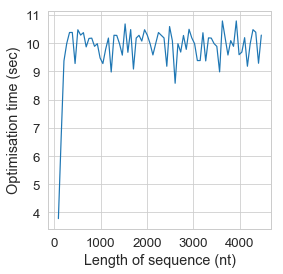

In [47]:
fig = plt.figure(figsize=(4, 4))
ax = sns.lineplot(x=seqs['Length'], y = seqs['time'], err_style="bars", ci=68)
ax.set(xlabel='Length of sequence (nt)', ylabel='Optimisation time (sec)')
plt.savefig("figs/benchmarking_1.pdf", bbox_inches = 'tight', pad_inches = 0)
plt.show()

In [ ]:
seqs.to_csv('results/benchmarking_1.csv', index=None)